# Proyecto final Inteligencia Computacional
## Style Transfer
### [Ammi Beltrán Troppa, Fernanda Borja Muñoz]

# Imports

In [1]:
import os
import io
import sys
import time
#
import numpy as np
import torch
from torch import nn
import torchvision
from matplotlib import pyplot as plt
#
import zipfile
#
from PIL import Image
from torch.utils.data import Dataset
from natsort import natsorted
from torchvision import datasets, transforms

# Encoder y Decoder

In [2]:
class Encoder(nn.Module):
  def __init__(self,layer = 3):
    super().__init__()
    fully_model = torchvision.models.vgg16(weights = torchvision.models.vgg.VGG16_Weights.DEFAULT).eval().features
    self.model = fully_model[:layer + 1]

  def forward(self,x):
    return self.model(x)

In [3]:
Encode = Encoder()
Encode

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Encoder(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
)

In [4]:
class Decoder(nn.Module):
  def __init__(self,layer = 5):
    super().__init__()
    fully_decoder = nn.Sequential(
        # Primera capa
        nn.Upsample(scale_factor=(2,2), mode='nearest'),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        
        # Segunda Capa
        nn.Upsample(scale_factor=(2,2), mode='nearest'),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),

        #Tercera Capa
        nn.Upsample(scale_factor=(2,2), mode='nearest'),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        

        #Cuarta Capa
        nn.Upsample(scale_factor=(2,2), mode='nearest'),
        nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        

        #Quinta Capa
        nn.Upsample(scale_factor=(2,2), mode='nearest'),
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True), 
    )
    self.model = fully_decoder[layer:29 ]

  def forward(self,x):
    return self.model(x)

In [5]:
Decode = Decoder(layer = 26)
Decode

Decoder(
  (model): Sequential(
    (26): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (27): ReLU(inplace=True)
    (28): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

# Data 

## Colab

In [6]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [10]:
# !cp /content/drive/MyDrive/val2017.zip /content/
# !unzip -qo /content/val2017.zip -d /content/
# !rm /content/val2017.zip

In [7]:
!cp /content/drive/MyDrive/test2017.zip /content/
!unzip -qo /content/test2017.zip -d /content/
!rm /content/test2017.zip

In [8]:
dir = "/content/data/test2017"
obj = natsorted(os.listdir(dir))
# #Entonces puedo armar una lista con todas las direcciones
dirArray = []
for i in range(0, len(obj)):
   dirArray.append(os.path.join(dir, obj[i]))

In [9]:
len(dirArray)

40670

# Dataset

Transformaciones

In [11]:
#Transformación para imagenes 
transform1 = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])

Dataset Antiguo

In [12]:
class CustomDataSet(Dataset):
    def __init__(self, imagelist, transform, encoder):
        super().__init__()
        self.imagepaths = imagelist
        self.transform = transform
        self.encoder = encoder

    def __len__(self):
        return len(self.imagepaths)

    def __getitem__(self, index):
        imagepath = self.imagepaths[index]
        image = Image.open(imagepath).convert('RGB')
        
        Norm_image = self.transform(image)
        feature = self.encoder(Norm_image.to('cuda'))
        
        return feature.cpu(), Norm_image.cpu()

In [13]:
Data = CustomDataSet(dirArray[:40600],transform = transform1, encoder = Encode)
Val = CustomDataSet(dirArray[40600:40670],transform = transform1, encoder = Encode)

# Código entrenamiento

In [14]:
class DecoderLoss(nn.Module):
  def __init__(self,weight = 1):
    super().__init__()
    self.weight = weight
  
  def forward(self, ydif, fdif): 
    reconst = torch.norm(ydif)**2
    features = self.weight * torch.norm(fdif)**2
    return reconst + features
  

In [15]:
def show_curves(curves):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax2.plot(epochs, curves['train_loss'], label='Training',color='r')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss evolution during training (Training)')
    ax2.legend()


    ax1.plot(epochs, curves['val_loss'], label='Validation', color='b')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss evolution during training (Validation)')
    ax1.legend()

    plt.show()

In [16]:
def train_step(x_batch, y_batch, model, optimizer, criterion, deco,use_gpu = False ):
    # Predicción
    y_predicted = model(x_batch)

    ydif = y_predicted - y_batch
    fdif = deco(y_predicted) - x_batch

    # Cálculo de loss
    loss = criterion(ydif, fdif)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss

def evaluate(val_loader, model, criterion, deco , use_gpu = False):
    cumulative_loss = 0

    for x_val, y_val in val_loader:

        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        ydif = y_predicted - y_val
        fdif = deco(y_predicted) - x_val

        
        loss = criterion(ydif, fdif)

        cumulative_loss += loss.item()
        

    val_loss = cumulative_loss / len(val_loader)
    del x_val,y_val

    return val_loss


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=1,
    use_gpu=False,
    name = 'Deco',
    Losses = 'Loss1L',
    deco = Encode
):
    deco.cpu()
    model.cpu()
    if use_gpu:
        model.cuda()
        Encode.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= int(len(val_dataset)/2), shuffle=False, pin_memory=use_gpu) 

    # Listas para guardar curvas de entrenamiento
    if  os.path.exists(Losses + ".pt"):
        curves = torch.load(f'{Losses}.pt')
    else:
        curves = {
            "train_loss": [],
            "val_loss": [],
        }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    #best_valid_loss = float('inf')

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        train_loss_count = 0

        # Optimizador
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, deco,use_gpu )

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            


            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}")

            iteration += 1
        del x_batch,y_batch

        model.eval()
        with torch.no_grad():
            val_loss = evaluate(val_loader, model, criterion,deco, use_gpu)
            

        # if val_loss < best_valid_loss:
        #     best_valid_loss = val_loss
        torch.save(model.state_dict(), f'{name}{epoch + 1}epc.pt')

        print(f"Val loss: {val_loss}")

        train_loss = cumulative_train_loss / train_loss_count

        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        torch.save(curves, f'{Losses}.pt')

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    #model.load_state_dict(torch.load(f'{name}.pt'))
    return show_curves(curves) #Descomentar esto para mostrar curvas de entrenamiento 

# Entrenamiento

### Forma nueva

Se han truncado las últimas 5000 líneas del flujo de salida.
Iteration 426 - Batch 426/903 - Train loss: 12892515.426229509
Iteration 427 - Batch 427/903 - Train loss: 12874260.093457945
Iteration 428 - Batch 428/903 - Train loss: 12855788.07925408
Iteration 429 - Batch 429/903 - Train loss: 12837449.272093024
Iteration 430 - Batch 430/903 - Train loss: 12818834.436194895
Iteration 431 - Batch 431/903 - Train loss: 12799775.054398147
Iteration 432 - Batch 432/903 - Train loss: 12782943.92147806
Iteration 433 - Batch 433/903 - Train loss: 12765327.115207374
Iteration 434 - Batch 434/903 - Train loss: 12748005.92183908
Iteration 435 - Batch 435/903 - Train loss: 12729874.68119266
Iteration 436 - Batch 436/903 - Train loss: 12711998.835240275
Iteration 437 - Batch 437/903 - Train loss: 12695140.942922374
Iteration 438 - Batch 438/903 - Train loss: 12678330.014806379
Iteration 439 - Batch 439/903 - Train loss: 12661315.4375
Iteration 440 - Batch 440/903 - Train loss: 12644106.8707483
Itera

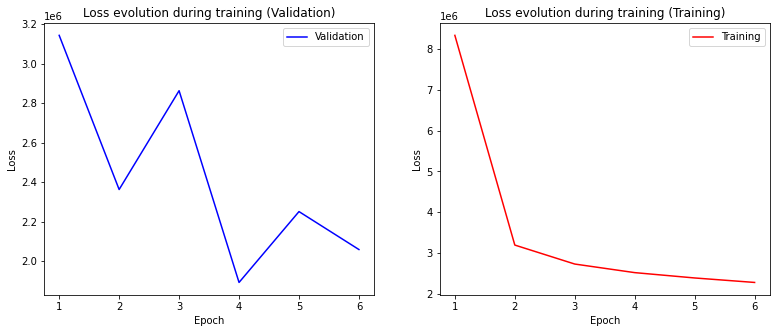

In [ ]:
epochs = 6
criterion = DecoderLoss()
batch_size = 45
lr = 1 * 10**(-3)
use_gpu = True

train_model(
    model = Decode,
    train_dataset = Data, val_dataset = Val,
    epochs = epochs, 
    criterion = criterion,
    batch_size = batch_size, lr = lr,
    use_gpu = use_gpu,
    n_evaluations_per_epoch = 500, #Cada cuantos batches te muestra el progreso de loss de entrenamiento
    name='Deco1FULL',               #Nombre de como queremos que se guarde el modelo resultante de cada época
    Losses = 'Loss1L'               #Nombre de los outputs de loss por época
    )